In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

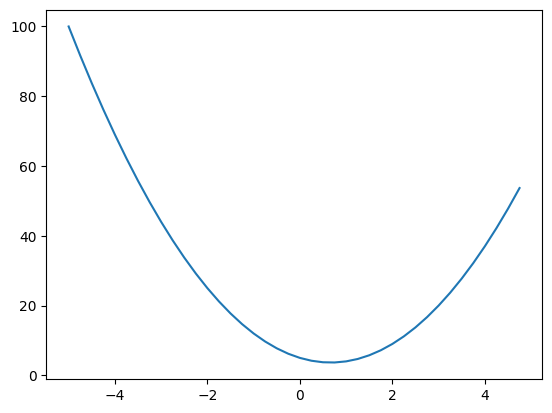

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000000000001
x = -3.0
(f(x+h) - f(x)) / h

-22.026824808563106

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## 1. Value class

In [62]:
class Value:
  
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
	def __repr__(self):
		return f"Value(data={self.data})"
	
	def __add__(self, other):
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += 1.0 * out.grad
			other.grad += 1.0 * out.grad
		out._backward = _backward
		return out

	def __mul__(self, other):
		out = Value(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += out.grad * other.data
			other.grad += out.grad * self.data
		out._backward = _backward
		return out

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self, ), 'tanh')

		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)

		self.grad = 1.0
		for node in reversed(topo):
			node._backward()
	
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L


Value(data=-8.0)

In [9]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
L.grad = 1.0

In [13]:
f.grad = 4.0

In [14]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [15]:
e.grad = -2.0
c.grad = -2.0

In [ ]:
draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [57]:
def lol():

	h = 0.0001
	a = Value(2.0, label='a')
	b = Value(-3.0, label='b')
	c = Value(10.0, label='c')
	e = a*b; e.label = 'e'
	d = e + c; d.label = 'd'
	f = Value(-2.0, label='f')
	L = d*f; L.label = 'L'
	L1 = L.data

	a = Value(2.0, label='a')
	b = Value(-3.0, label='b')
	c = Value(10.0, label='c')
	e = a*b; e.label = 'e'
	d = e + c; d.label = 'd'
	f = Value(-2.0, label='f')
	L = d*f; L.label = 'L'
	L2 = L.data

	print((L2 - L1) / h)

lol()

0.0


## 2. tanh function

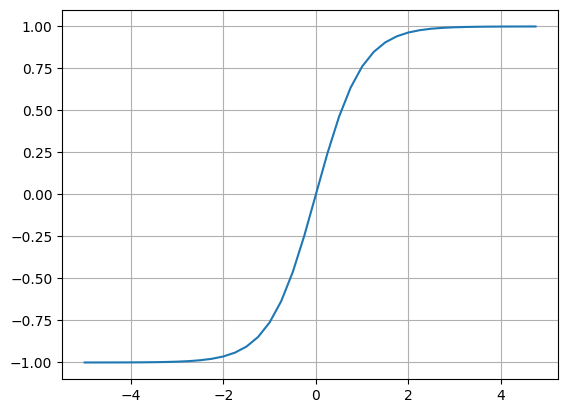

In [23]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()

In [54]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
draw_dot(o)

In [20]:
o.grad = 1.0

In [23]:
o.data

0.7071067811865476

o = tanh(n)

do/dn = 1 - tanh(n)**2 = 1 - o**2

In [24]:
1 - o.data**2

0.4999999999999999

In [25]:
n.grad = 0.5

In [26]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [27]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [28]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [29]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## 3. 위 과정을 _backward 함수로 진행

In [33]:
o.grad = 1.0 #initialize

In [34]:
o._backward()

In [36]:
n.grad

0.4999999999999999

In [37]:
n._backward()

In [38]:
print(b.grad)
print(x1w1x2w2.grad)

0.4999999999999999
0.4999999999999999


In [39]:
b._backward()

In [40]:
x1w1x2w2._backward()

In [41]:
print(x1w1.grad)
print(x2w2.grad)

0.4999999999999999
0.4999999999999999


In [42]:
x1w1._backward()
x2w2._backward()
print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)

-1.4999999999999996
0.9999999999999998
0.4999999999999999
0.0


## 4. topological sort 도입

In [43]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [45]:
o.grad = 1.0

topo = []
build_topo(o)

for node in reversed(topo):
  node._backward()

print(b.grad)
print(w1.grad)
print(w2.grad)
print(x1.grad)
print(x2.grad)

0.4999999999999999
0.9999999999999998
0.0
-1.4999999999999996
0.4999999999999999


## 5. Run backward after adding a backward function to Value class

In [63]:
# 재정의
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [58]:
o.backward()
print(o.grad)
print(b.grad)
print(w1.grad)
print(w2.grad)
print(x1.grad)
print(x2.grad)

1.0
0.4999999999999999
0.9999999999999998
0.0
-1.4999999999999996
0.4999999999999999


## 6. Debug

In [61]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
print(a.grad) # 1.0
# 원래 b=2a에서 a로 미분하면 2인데?? -> a를 self와 other로 취급하기 때문

1.0


In [64]:
# self.grad += 1.0 * out.grad
# other.grad += 1.0 * out.grad

In [65]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
print(a.grad)

2.0


---
# 여러 계산 method 구현

In [15]:
class Value:
  
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
	def __repr__(self):
		return f"Value(data={self.data})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += 1.0 * out.grad
			other.grad += 1.0 * out.grad
		out._backward = _backward
		return out

	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += out.grad * other.data
			other.grad += out.grad * self.data
		out._backward = _backward
		return out
	
	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only supporting int/float powers for now"
		out = Value(self.data**other, (self, ), f'**{other}')

		def _backward():
			self.grad += other * (self.data**(other-1)) * out.grad
		out._backward = _backward
		
		return out
	
	def __rmul__(self, other):
		return self * other
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self, ), 'tanh')

		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self, ), 'exp')

		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)

		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# tanh 직접 구현 ---
e = (2*n).exp()
o = (e-1) / (e+1)
# ---
o.label = 'o'
o.backward()

---
# By Pytorch!

In [18]:
import torch

In [19]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
x2.grad

tensor([0.5000], dtype=torch.float64)

# Build neuralnet by pytorch

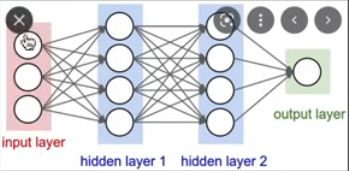

In [31]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w*x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 그림 참고: 3개 입력 -> 4개 hidden state -> 4개 hidden state -> 1개 출력
n(x)

Value(data=0.3886642063217275)

In [33]:
len(n.parameters())

41

## Example

In [49]:
xs = [
  [2.0, 3.0, -1.0], 
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
# xs의 각각의 원소를 위 neuralnet에 태운게 아래 ys (desired targets)가 되어야 함
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred


[Value(data=0.9983558423548246),
 Value(data=-0.9999435199619784),
 Value(data=-0.7963729249386833),
 Value(data=0.9970028416922955)]

In [50]:
# 학습시키기 위해 loss를 사용: MSELoss
loss = Value(0.0)
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=loss)
loss

Value(data=0.04147567510030544)

In [36]:
loss.backward()

In [37]:
n.layers[0].neurons[0].w[0].grad

-0.028583211048652656

In [38]:
n.layers[0].neurons[0].w[0].data

-0.9695757488314067

In [39]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [41]:
n.layers[0].neurons[0].w[0].data
# 이 뉴런의 데이터의 gradient 값 (loss에 대한 이 뉴런의 gradient 값)이 음수이기 때문에, 이 데이터가 더 커져야, loss가 줄어듬

-0.9692899167209202

In [46]:
ypred = [n(x) for x in xs]
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))
loss

Value(data=4.017708470096568)

In [51]:
# 반복
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # zero grad
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad


  print(k, loss.data)

0 0.04147567510030544
1 0.031117677339366104
2 0.024829378931843976
3 0.020613953423245897
4 0.017596355396784204
5 0.015332540052258545
6 0.01357331670931863
7 0.01216812791388033
8 0.011020703629211094
9 0.01006665375826286
10 0.009261304349612486
11 0.008572702934878147
12 0.007977401047445203
13 0.007457808153299736
14 0.007000474358225881
15 0.00659494289378885
16 0.006232963588026497
17 0.005907941567440125
18 0.005614543096729755
19 0.005348408729913974


In [52]:
ypred # 거의 비슷한 결과 !

[Value(data=0.9983277082914687),
 Value(data=-0.9999444773041521),
 Value(data=-0.9269522869065064),
 Value(data=0.9968950524325769)]